In [1]:

"""
copy from kaggle
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator # mageDataGenerator()是keras.preprocessing.image模块中的图片生成器，同时也可以在batch中对数据进行增强，扩充数据集大小，增强模型的泛化能力。比如进行旋转，变形，归一化等等。

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output # 父进程等待子进程完成, 返回子进程向标准输出的输出结果
print(check_output(["ls", "./"]).decode("utf8")) # 打印目录下的文件列表

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


cnn_keras.ipynb
cnn_mnist_datagen.csv
digit-recognizer.zip
sample_submission.csv
test.csv
test.ipynb
train.csv
Untitled.ipynb



In [2]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("./train.csv") # 读取训练集
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test= pd.read_csv("./test.csv")  # 读取测试集
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values   训练集的特征
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits  训练集的label
X_test = test.values.astype('float32')       # 测试集的特征

In [5]:
X_train  

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

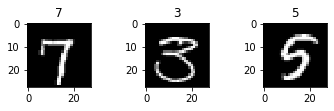

In [7]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28) # 从num_images*784 转成 num_images*28*28

for i in range(6, 9):  # range(6, 9)得到[6,7,8]
    plt.subplot(330 + (i+1)) # plt.subplot(337), plt.subplot(338), plt.subplot(339)三行三列，第7，8，9个图
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray')) # 显示图片
    plt.title(y_train[i])  # 图片标题

In [8]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1) # 转成num_images*28*28*1,1表示通道
X_train.shape

(42000, 28, 28, 1)

In [9]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1) # 转成num_images*28*28*1,1表示通道
X_test.shape

(28000, 28, 28, 1)

In [10]:
mean_px = X_train.mean().astype(np.float32) # 计算每列的平均值
std_px = X_train.std().astype(np.float32)   # 计算每列的标准差

def standardize(x):           # 标准化
    return (x-mean_px)/std_px

In [11]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)        # one-hot编码
num_classes = y_train.shape[1]          # 列数
num_classes

10

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


([<matplotlib.axis.XTick at 0x7ff9fcf9a128>,
 <a list of 10 Text xticklabel objects>)

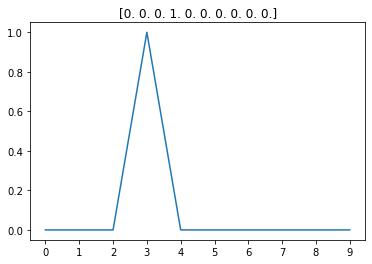

In [12]:
plt.title(y_train[9]) # 标题：第9个样本的label
plt.plot(y_train[9])  # 折线图
plt.xticks(range(10)) # x轴

In [13]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

In [14]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

In [15]:
model= Sequential()  # 序贯模型
model.add(Lambda(standardize,input_shape=(28,28,1)))   # lambda层
model.add(Flatten())                  # 展平
model.add(Dense(10, activation='softmax'))  # 全连接层，softmax
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [16]:
from keras.optimizers import RMSprop      
model.compile(optimizer=RMSprop(lr=0.001),    
loss='categorical_crossentropy',
metrics=['accuracy'])#编译模型，rmsprop优化器，学习率0.001，交叉熵损失函数， 评价指标为准确率

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
from keras.preprocessing import image
gen = image.ImageDataGenerator() # 图片处理器

In [18]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)  # 分割训练集和测试集
batches = gen.flow(X_train, y_train, batch_size=64) # 生成的是一个迭代器，可直接用于for循环
val_batches=gen.flow(X_val, y_val, batch_size=64)   # 生成的是一个迭代器，可直接用于for循环

In [19]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)  # 利用Python的生成器，逐个生成数据的batch并进行训练。生成器与模型将并行执行以提高效率。

Epoch 1/3
  591/37800 [..............................] - ETA: 1:21 - loss: 0.2856 - acc: 0.9193 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

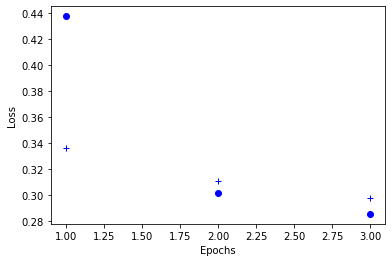

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']           # 训练集的损失值
val_loss_values = history_dict['val_loss']   # 验证集的损失值
epochs = range(1, len(loss_values) + 1)      # 训练轮数

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')  # 用蓝色圆点表示        
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')   # 用蓝色+表示
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

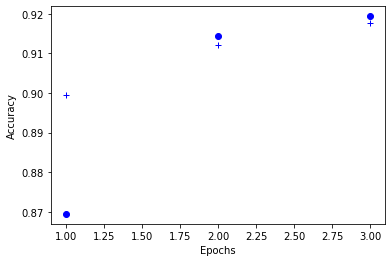

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['acc']           # 训练集准确率
val_acc_values = history_dict['val_acc']   # 验证集准确率

plt.plot(epochs, acc_values, 'bo') 
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [23]:
def get_fc_model():          # 构建模型的函数
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),      # lambda层
        Flatten(),                           # 展平
        Dense(512, activation='relu'),       # 全连接层512个节点，relu激活
        Dense(10, activation='softmax')      # 全连接层10个节点，softmax激活
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])        # 模型编译， adam优化器， 交叉熵损失函数，准确率指标
    return model

In [24]:
fc = get_fc_model()       # 得到模型
fc.optimizer.lr=0.01      # 设置学习率0.01

In [25]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n) # 训练

Epoch 1/1
  591/37800 [..............................] - ETA: 4:31 - loss: 0.8500 - acc: 0.8803 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00

In [26]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():                                   # 构造卷积神经网络
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),    # lambda层
        Convolution2D(32,(3,3), activation='relu'),    # 卷积层
        Convolution2D(32,(3,3), activation='relu'),    # 卷积层
        MaxPooling2D(),                                # 最大池化层
        Convolution2D(64,(3,3), activation='relu'),    # 卷积层
        Convolution2D(64,(3,3), activation='relu'),    # 卷积层
        MaxPooling2D(),                                # 最大池化层
        Flatten(),                                     # 展平
        Dense(512, activation='relu'),                 # 全连接层
        Dense(10, activation='softmax')                # 全连接层softmax
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])                # 模型编译，优化器adam, 交叉熵损失函数，准确率指标
    return model

In [27]:
model= get_cnn_model()                # 得到cnn模型
model.optimizer.lr=0.01               # 设置学习率

In [28]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)      # 训练

Epoch 1/1
  591/37800 [..............................] - ETA: 1:19:55 - loss: 0.3085 - acc: 0.9043 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00

In [29]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)   # 图片处理
batches = gen.flow(X_train, y_train, batch_size=64)     # 迭代器
val_batches = gen.flow(X_val, y_val, batch_size=64)     # 迭代器

In [30]:
model.optimizer.lr=0.001                                # 设置学习率
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)   # 模型训练

Epoch 1/1
  591/37800 [..............................] - ETA: 1:19:36 - loss: 0.2698 - acc: 0.9176 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00

In [31]:
from keras.layers.normalization import BatchNormalization

def get_bn_model():                              
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),         # lambda层
        Convolution2D(32,(3,3), activation='relu'),         # 卷积层
        BatchNormalization(axis=1),                         # 批标准化
        Convolution2D(32,(3,3), activation='relu'),         # 卷积层
        MaxPooling2D(),                                     # 最大池化层
        BatchNormalization(axis=1),                         # 批标准化
        Convolution2D(64,(3,3), activation='relu'),         # 卷积层
        BatchNormalization(axis=1),                         # 批标准化
        Convolution2D(64,(3,3), activation='relu'),         # 卷积层
        MaxPooling2D(),                                     # 最大池化层
        Flatten(),                                          # 展平
        BatchNormalization(),                               # 批标准化
        Dense(512, activation='relu'),                      # 全连接层
        BatchNormalization(),                               # 批标准化
        Dense(10, activation='softmax')                     # 全连接层，输出
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])   # 编译模型，adam优化器，交叉熵损失函数，准确率指标
    return model

In [ ]:
model= get_bn_model()                        # 得到模型
model.optimizer.lr=0.01                      # 设置学习率0.01
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)   # 训练

Epoch 1/1
  582/37800 [..............................] - ETA: 3:28:09 - loss: 0.2616 - acc: 0.9269

In [ ]:
model.optimizer.lr=0.01    # 设置学习率
gen = image.ImageDataGenerator()  
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)  # 训练

In [ ]:
predictions = model.predict_classes(X_test, verbose=0)        # 预测

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})       # 将预测结果转成df
submissions.to_csv("DR.csv", index=False, header=True)    # 保存结果